In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
np.random.seed(1)

In [6]:
data = pd.read_csv('train.csv')

In [7]:
wm = lambda x: np.average(x, weights=data.loc[x.index, "weight"])

In [8]:
data.groupby('date')['resp'].agg(['max', 'min', wm])

,max,min,<lambda_0>
date,,,
0,0.180969,-0.168365,0.001075
1,0.163026,-0.217967,-0.000037
2,0.010591,-0.021352,-0.002450
3,0.224508,-0.200134,-0.001045
4,0.134086,-0.210788,0.000449
...,...,...,...
495,0.208718,-0.305227,0.001111
496,0.229697,-0.258179,-0.001054
497,0.221675,-0.329001,0.000497


In [10]:
for f in ['feature_' + str(i) for i in range(130)]:
    data[f + '_sq'] = data[f].apply(lambda x: x**2)
    data[f + '_lag'] = data[f].shift()
features = data.columns.str.contains('feature')
features = data.columns[features]

In [11]:
remove_cols = ['feature_60', 'feature_62', 'feature_64', 'feature_65', 'feature_67']
features = [c for c in features if c not in remove_cols]

In [12]:
norms = data.dropna()[features].apply(lambda x: np.linalg.norm(x, axis=0))
data_norm = data
data_norm[features] = data_norm[features] / norms
data_norm[features]
del data

<AxesSubplot:>

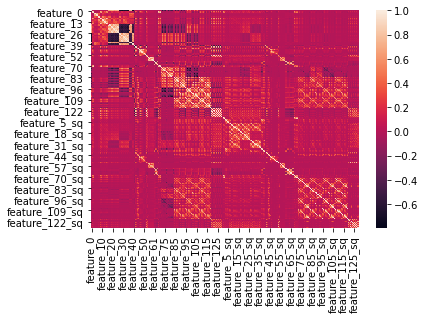

In [13]:
corr = pd.DataFrame(data_norm[features]).corr()
sns.heatmap(corr)

In [14]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if 0.8 <= corr.iloc[i,j] <= -0.8:
            if columns[j]:
                columns[j] = False
selected_columns = data_norm[features].columns[columns]
len(selected_columns)

149

In [15]:
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        print(i, numVars, i / numVars)
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.001
data_modeled, selected_columns = backwardElimination(data_norm.dropna()[selected_columns].values, data_norm.dropna()['resp'].values, SL, selected_columns)

0 149 0.0
1 149 0.006711409395973154
2 149 0.013422818791946308
3 149 0.020134228187919462
4 149 0.026845637583892617
5 149 0.03355704697986577
6 149 0.040268456375838924
7 149 0.04697986577181208
8 149 0.053691275167785234
9 149 0.06040268456375839
10 149 0.06711409395973154
11 149 0.0738255033557047
12 149 0.08053691275167785
13 149 0.087248322147651
14 149 0.09395973154362416
15 149 0.10067114093959731
16 149 0.10738255033557047
17 149 0.11409395973154363
18 149 0.12080536912751678
19 149 0.12751677852348994
20 149 0.1342281879194631
21 149 0.14093959731543623
22 149 0.1476510067114094
23 149 0.15436241610738255
24 149 0.1610738255033557
25 149 0.16778523489932887
26 149 0.174496644295302
27 149 0.18120805369127516
28 149 0.18791946308724833
29 149 0.19463087248322147
30 149 0.20134228187919462
31 149 0.2080536912751678
32 149 0.21476510067114093
33 149 0.2214765100671141
34 149 0.22818791946308725
35 149 0.2348993288590604
36 149 0.24161073825503357
37 149 0.2483221476510067
38 149

In [16]:
selected_columns

Index(['feature_0', 'feature_1', 'feature_3', 'feature_7', 'feature_9',
       'feature_11', 'feature_13', 'feature_17', 'feature_19', 'feature_27',
       ...
       'feature_83_sq', 'feature_86_sq', 'feature_88_sq', 'feature_89_sq',
       'feature_91_sq', 'feature_95_sq', 'feature_100_sq', 'feature_104_sq',
       'feature_112_sq', 'feature_121_sq'],
      dtype='object', length=105)

In [ ]:
result = pd.DataFrame()
result['pnl'] = data_norm['resp']

fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_norm[selected_columns].columns:
    plt.subplot(11, 4, j+1)
    j += 1
    sns.distplot(data[i][result['pnl']>0], color='g', label = 'gain')
    sns.distplot(data[i][result['pnl']<0], color='r', label = 'loss')
    plt.legend(loc='best')
fig.suptitle('PnL')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
remove_cols = ['feature_60', 'feature_62', 'feature_64', 'feature_65', 'feature_67']
selected_columns = [c for c in selected_columns if c not in remove_cols]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data.dropna()[selected_columns]), data.dropna()['resp'].values, test_size = 0.2)

In [ ]:
svr=SVR()
svr.fit(x_train, y_train)

In [ ]:
prediction = svr.predict(x_test)

In [17]:
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

In [18]:
train = data_norm
train['action'] = (train['resp'].values > 0).astype('int')
train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121_sq,feature_122_sq,feature_123_sq,feature_124_sq,feature_125_sq,feature_126_sq,feature_127_sq,feature_128_sq,feature_129_sq,action
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,0.000708,-0.000517,-0.000632,...,NaN,0.000077,0.001472,0.000247,0.014831,0.000323,0.013394,0.000266,0.006992,1
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-0.000708,-0.000372,-0.000491,...,NaN,0.000078,0.000067,0.000065,0.000605,0.000092,0.000445,0.000086,0.000192,0
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-0.000708,0.000224,-0.000074,...,NaN,0.002096,0.001990,0.002392,0.010282,0.002435,0.008538,0.002214,0.004743,1
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-0.000708,0.000324,0.000099,...,NaN,0.000452,0.000005,0.000717,0.000173,0.000888,0.000135,0.000747,0.000055,0
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,0.000708,-0.000875,-0.000892,...,NaN,0.000007,0.000358,0.000029,0.003311,0.000029,0.002310,0.000007,0.000823,0


In [19]:
import xgboost as xgb

In [20]:
X_train = train.loc[:, selected_columns]
y_train = train.loc[:, 'action']
X_train = X_train.fillna(-999)

In [21]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.01,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2020,
    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)

In [22]:
%time clf.fit(X_train, y_train)

CPU times: user 15h 2min 25s, sys: 1min 59s, total: 15h 4min 25s
Wall time: 1h 57min 24s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=-999, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              random_state=2020, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [23]:
for (test_df, sample_prediction_df) in iter_test:
    X_test = test_df.loc[:, selected_columns]
    norms = X_test.dropna()[selected_columns].apply(lambda x: np.linalg.norm(x, axis=0))
    X_test[selected_columns] = X_test[selected_columns] / norms
    X_test.fillna(-999)
    y_preds = clf.predict(X_test)
    sample_prediction_df.action = y_preds
    env.predict(sample_prediction_df)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['feature_0_sq', 'feature_1_sq', 'feature_3_sq', 'feature_4_sq',\n       'feature_5_sq',\n       ...\n       'feature_95_sq', 'feature_100_sq', 'feature_104_sq', 'feature_112_sq',\n       'feature_121_sq'],\n      dtype='object', length=62). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"